<a href="https://colab.research.google.com/github/alklyatov/ML-DL_LR/blob/main/LR_4_Klyatov_Shilov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Отчет по лабораторной работе № 4**

Выполнили студенты группы ИУ10-91:
Клятов Алексей, Шилов Елисей

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

Подготовка данных:

In [ ]:
data = pd.read_csv('/content/NetflixOriginals.csv', sep=',',encoding='latin-1')
data = data.drop(['Title','Genre'],axis = 'columns')

import re
premier = data['Premiere']
for i in range(len(premier)):
  premier[i] = int(re.sub('.+ \d+. ', '', str(premier[i])))
data['Premiere'] = data['Premiere'].astype('int')

rating = data['IMDB Score']
for i in range (len(rating)):
  if rating[i] >= 6: rating[i] = 1
  else: rating[i] = 0
data['IMDB Score'] = data['IMDB Score'].astype('int')

train_data = np.dstack((data['Premiere'].to_numpy(),  data['Runtime'].to_numpy()))[0]
train_labels = data['IMDB Score'].to_numpy()

Выбрано три параметра: год выхода сериала в прокат, его длительность и "булевый рейтинг" (целевой признак) - если балл на IMDB >= 6, то он приравнивается к 1, в противном случае  - к 0. Отображение данных: 

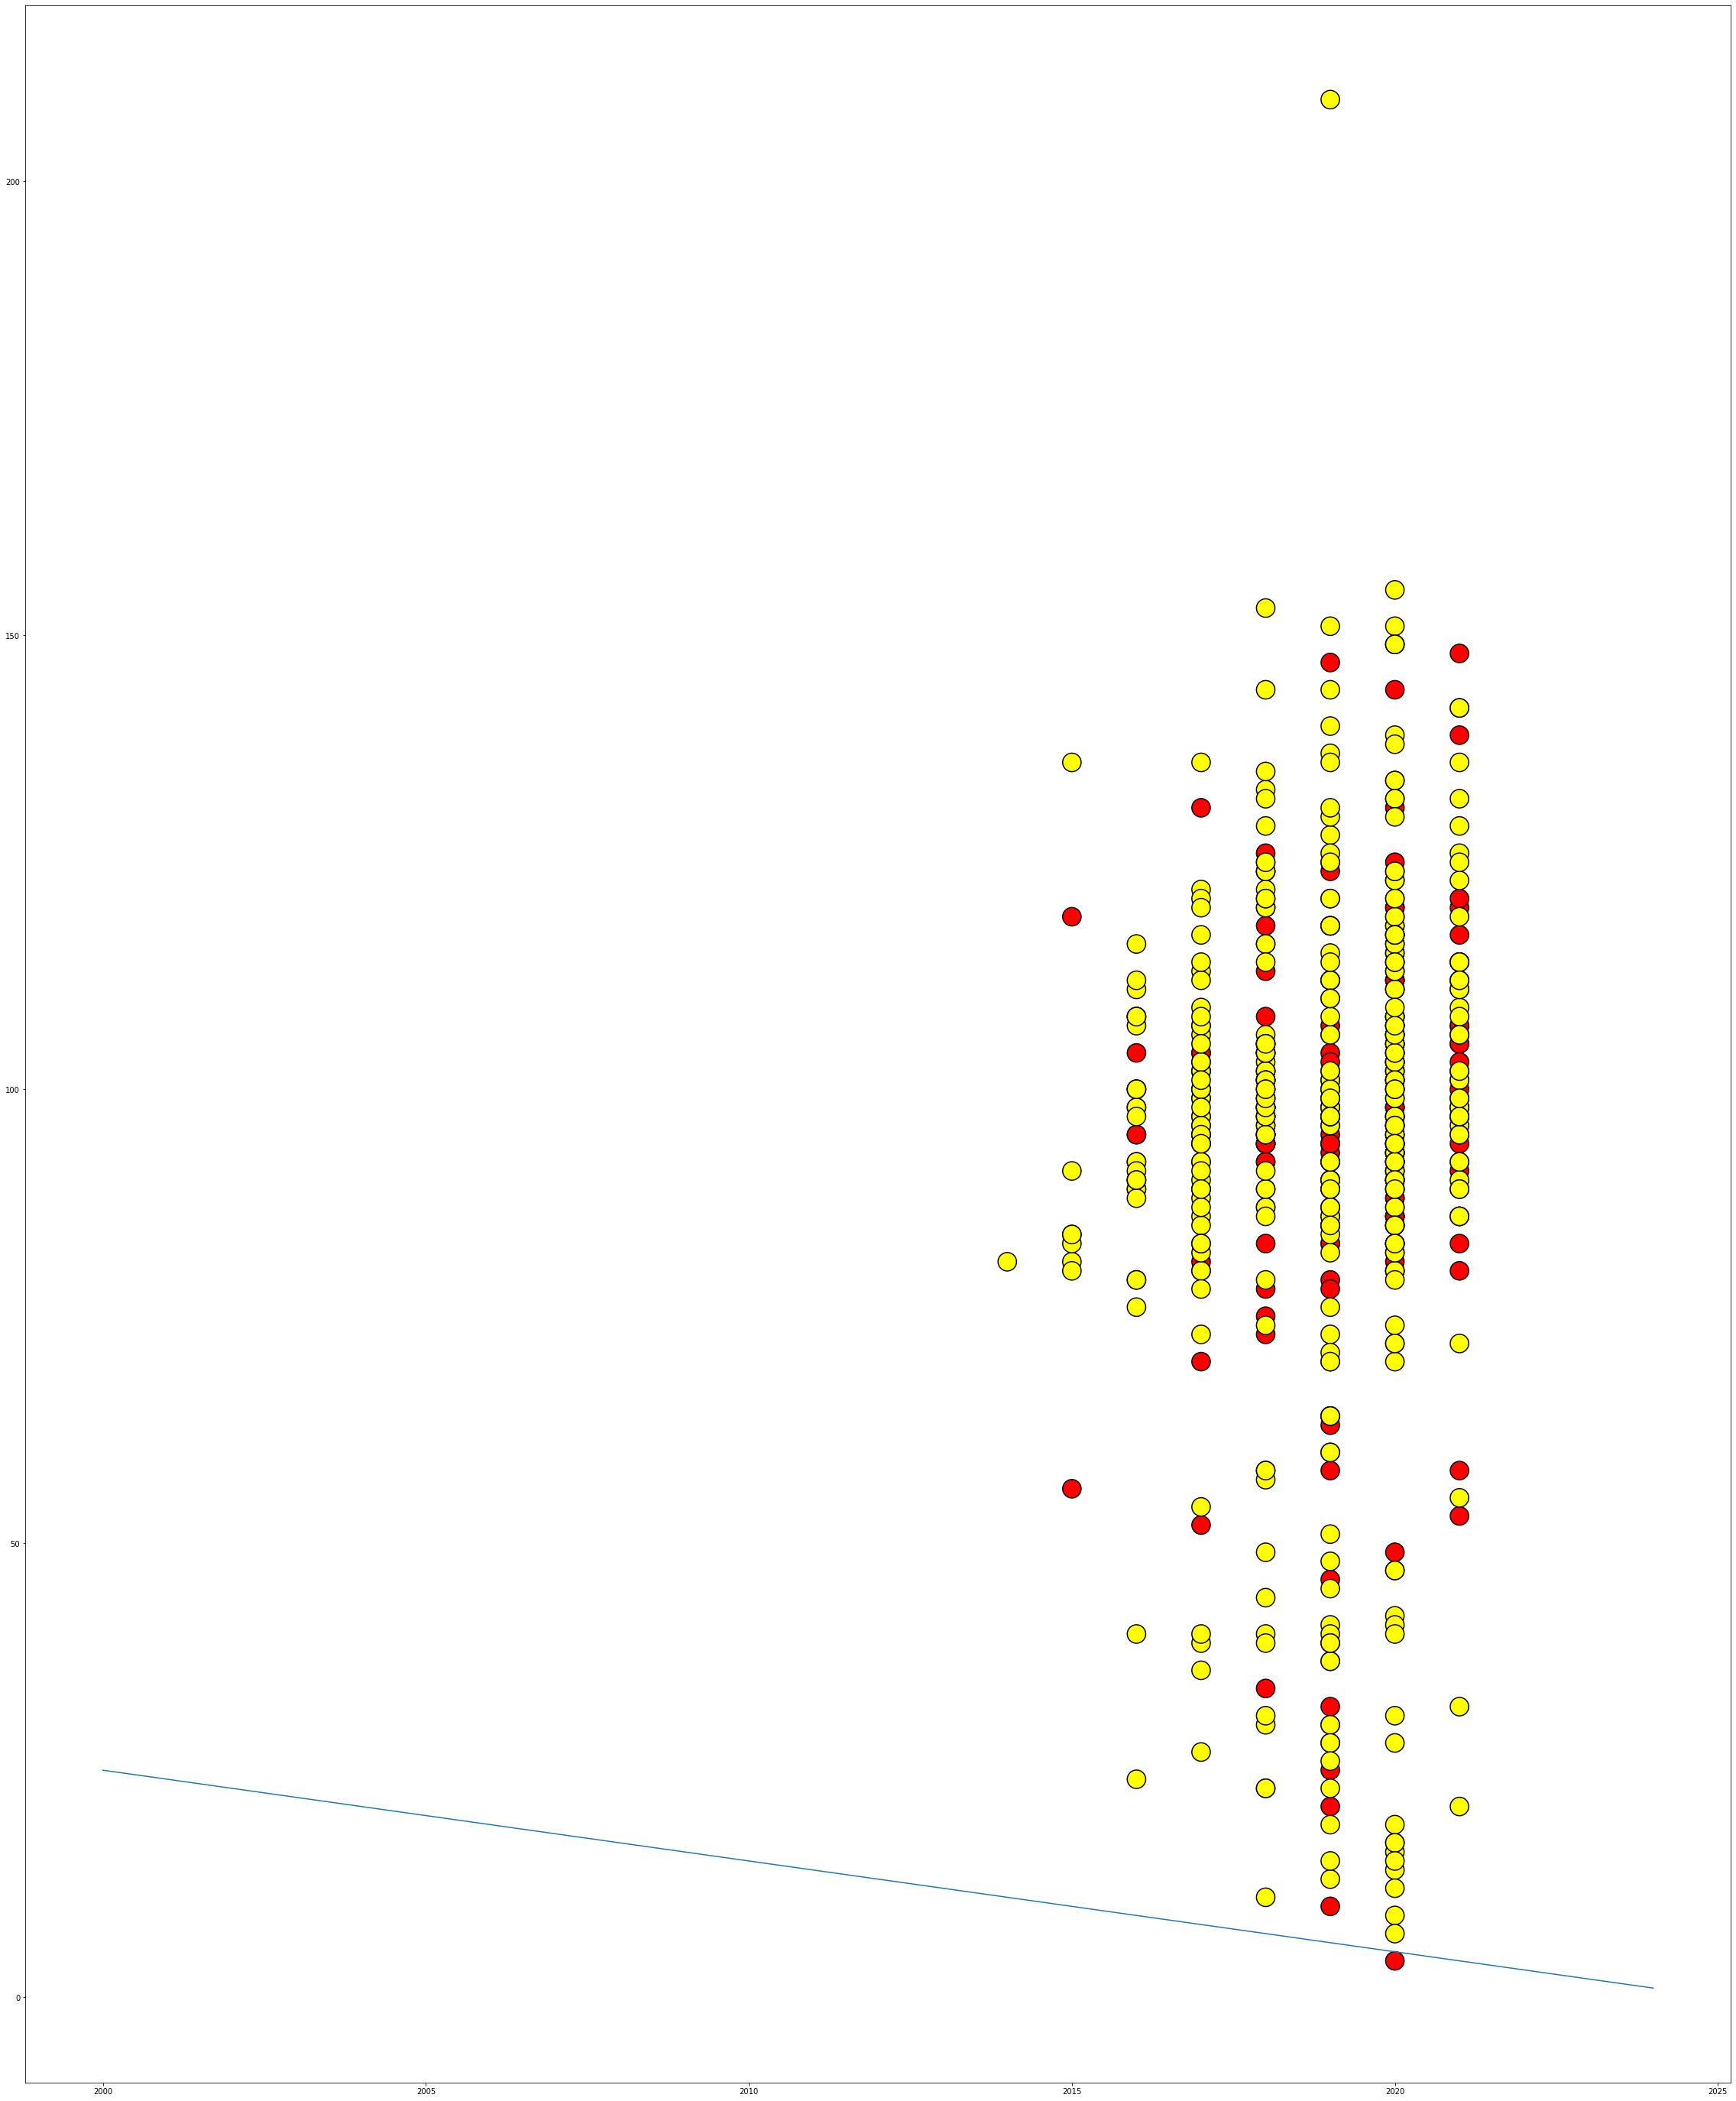

In [ ]:
plt.rcParams['figure.figsize'] = (40,50)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=584, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(2000,2025), range(25,0,-1));

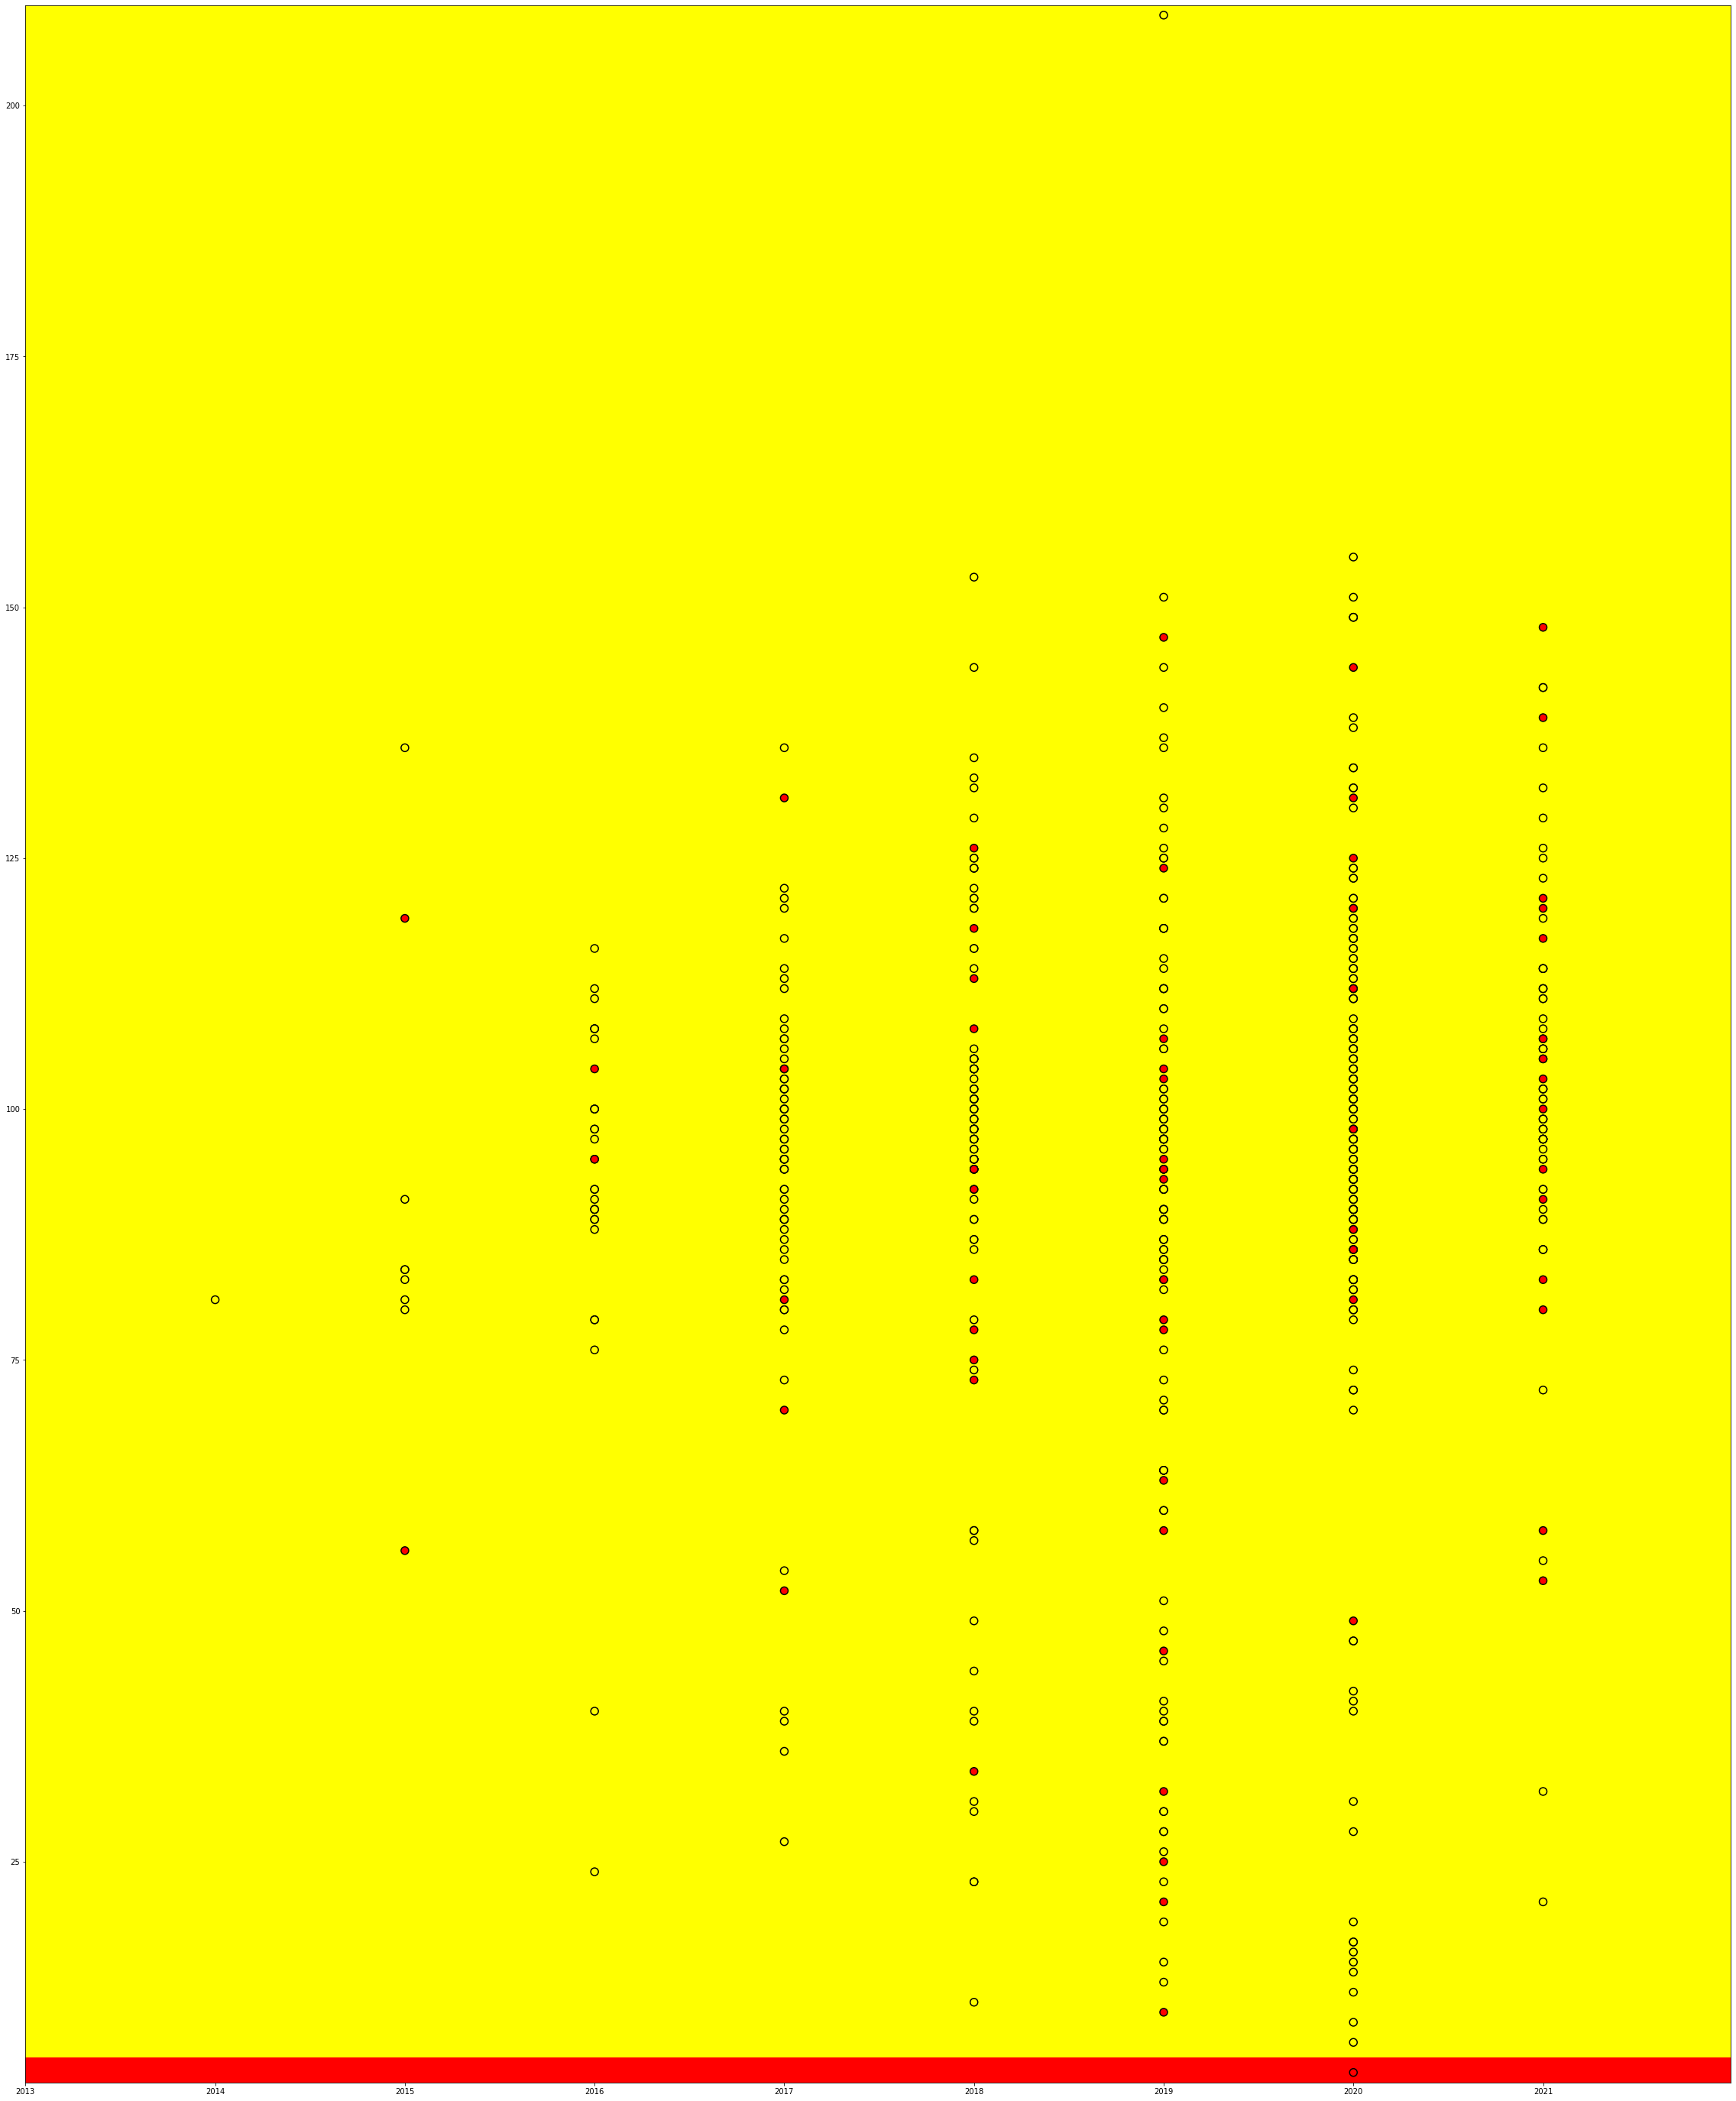

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
clf_tree.fit(train_data, train_labels)

xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

Визуализируем дерево:

In [ ]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x048\x00\x00\x01\xf1\x08\x02\x00\x00\x00\x07\xad\x9b…

Точность:

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_labels, test_size=0.3, random_state=17
)

first_tree = DecisionTreeClassifier(random_state=17)
first_tree.fit(X_train, y_train)
y_pred =  first_tree.predict(X_test)
print('Precision with test data: ', accuracy_score(y_true = y_test, y_pred = y_pred))

Precision with test data:  0.5965909090909091


Пятикратное обучение дерева:

In [ ]:
precision_scores = cross_val_score(first_tree, X_train, y_train, cv=5)
for i in range(0, len(precision_scores), 1):
  print(i + 1, ' score: ', precision_scores[i])

1  score:  0.5487804878048781
2  score:  0.5975609756097561
3  score:  0.5853658536585366
4  score:  0.6049382716049383
5  score:  0.4567901234567901


По результатам видно, что одиночное дерево нестабильно.

### Отбор самых важных признаков случайным деревом

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import  RandomForestClassifier


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)

from sklearn import metrics
print("Precision score without cv: {:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

Precision score without cv: 58.52%


In [ ]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(rfc, train_data, train_labels, cv=skf)
print("Precision score using cv: {:.2f}%".format(results.mean()*100))

Precision score using cv: 58.38%


С кросс-валидацией точность стала немного хуже.

Выведем используемые признаки:

In [ ]:
print(rfc.feature_importances_)

col = [i for i in range(2)]
listValues = rfc.feature_importances_
myDict = {col[i]:listValues[i] for i in range(0, len(col), 1)} 
for key in myDict:
    print(key, '->', myDict[key])

[0.14027067 0.85972933]
0 -> 0.1402706714206784
1 -> 0.8597293285793216


В нашем случае их всего 2, поэтому будет несложно выбрать самый значимый из них (2й). Однако пренебрегать первым не будем.

In [ ]:
X = train_data
y = train_labels

X_train, X_test, y_train, y_test = train_test_split(X, y)

Теперь необходимо подобрать оптимальные параметры обучения.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best precision on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best precision on CV is 60.10% with 5 trees


Лучшая точность достигается при использовании 5 деревьев.

Теперь рассмотрим параметр "глубина"

Best accuracy on CV is 63.19% with 3 max_depth


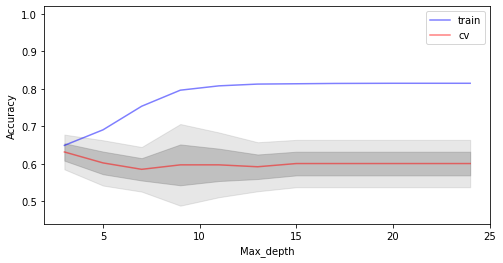

In [ ]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.44,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Лучшая точность при depth = 3.

Теперь - параметр min_samples_leaf:

In [ ]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 65.41% with 17 min_samples_leaf


Оптимальное значение параметра: 17.

##Градиентный бустинг

In [ ]:
!pip install catboost

In [ ]:
%%time

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 15, 1)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth).fit(X_train, y_train).predict(X_test)
        scores[i, j] = mean_squared_error(y_test, p)

Learning rate set to 0.5
0:	learn: 0.4745771	total: 199us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4745872	total: 392us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4745696	total: 323us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4725571	total: 399us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4712446	total: 511us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4712308	total: 677us	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4676763	total: 1.02ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4593359	total: 1.18ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4575293	total: 2.71ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4566673	total: 4.66ms	remaining: 0us
CPU times: user 87.4 ms, sys: 32.1 ms, total: 120 ms
Wall time: 321 ms


Случайный лес:

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor(max_depth = 3, max_features = 2, min_samples_leaf = 17).fit(X_train , y_train).predict(X_test)
res5 = mean_squared_error(y_test, linear_preds) ** 0.5
print(res5)

0.46409959028122205
CPU times: user 144 ms, sys: 819 µs, total: 144 ms
Wall time: 144 ms


В нашем случае случайны лес отработал бычтрее градиентного бустинга (144 мс против 321 мс соответственно)